## Imports

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from huggingface_hub import hf_hub_download

from uni2ts.eval_util.plot import plot_single
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from uni2ts.model.moirai_moe import MoiraiMoEForecast, MoiraiMoEModule

from ctf4science.data_module import load_validation_dataset, load_dataset, get_prediction_timesteps, get_validation_prediction_timesteps, get_validation_training_timesteps, get_metadata

/Users/alexey/Git/CTF-for-Science/models/uni2ts/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model Parameters

In [2]:
MODEL = "moirai-moe"  # model name: choose from {'moirai', 'moirai-moe'}
SIZE = "small"  # model size: choose from {'small', 'base', 'large'}
#PDT = 20  # prediction length: any positive integer
#CTX = 200  # context length: any positive integer
PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 32  # batch size: any positive integer
#TEST = 100  # test set length: any positive integer

## Data

In [3]:
# Pair ids 2, 4: reconstruction
# Pair ids 1, 3, 5-7: forecast
# Pair ids 8, 9: burn-in
pair_id = 2
dataset = 'ODE_Lorenz'
validation = True
recon_ctx = 100 # Context length for reconstruction

md = get_metadata(dataset)

if validation:
    train_data, val_data, init_data = load_validation_dataset(dataset, pair_id=pair_id)
    forecast_length = get_validation_prediction_timesteps(dataset, pair_id).shape[0]
else:
    train_data, init_data = load_dataset(dataset, pair_id=pair_id)
    forecast_length = get_prediction_timesteps(dataset, pair_id).shape[0]

print(f"Predicting {dataset} for pair {pair_id} with forecast length {forecast_length}")

delta_t = md['delta_t']

# Perform pair_id specific operations
if pair_id in [2, 4]:
    # Reconstruction
    train_mat = train_data[0]
    train_mat = train_mat[0:recon_ctx,:]
    df = pd.DataFrame(train_mat)
elif pair_id in [1, 3, 5, 6, 7]:
    # Forecast
    train_mat = train_data[0]
    df = pd.DataFrame(train_mat)
elif pair_id in [8, 9]:
    # Burn-in
    train_mat = init_data
    df = pd.DataFrame(train_mat)
else:
    raise ValueError(f"Pair id {pair_id} not supported")

# Model variables
PDT = forecast_length
CTX = df.shape[0]
TEST = forecast_length

# Append forecast_length of zeros to each column of the dataset
print("df shape before:", df.shape)
df = pd.concat([df, pd.DataFrame(np.zeros((forecast_length, df.shape[1])), columns=df.columns)], axis=0)
print("df shape after:", df.shape)

# Create DateTimeIndex starting from 0 seconds with delta_t intervals
start_time = pd.Timestamp('2020-01-01')  
timestamps = pd.date_range(start=start_time, 
                            periods=len(df),
                            freq=f'{delta_t}S')
df.index = timestamps

# Convert into GluonTS dataset with frequency in seconds
ds = PandasDataset(dict(df), freq=f'{delta_t}S')

print("CTX:", CTX)
print("PDT:", PDT)
print("TEST:", TEST)

print("Data head:")
display(df.head())
print("Data tail:")
display(df.tail())


Predicting ODE_Lorenz for pair 2 with forecast length 10000
df shape before: (100, 3)
df shape after: (10100, 3)
CTX: 50
PDT: 10
TEST: 10000
Data head:


,0,1,2
2020-01-01 00:00:00.000,0.239200,-10.937662,-4.639864
2020-01-01 00:00:00.050,-3.515230,-13.520588,-2.250493
2020-01-01 00:00:00.100,-8.652837,-23.661334,4.026295
2020-01-01 00:00:00.150,-16.720098,-33.193922,22.504044
2020-01-01 00:00:00.200,-21.878434,-23.970857,49.835697


Data tail:


,0,1,2
2020-01-01 00:08:24.750,0.0,0.0,0.0
2020-01-01 00:08:24.800,0.0,0.0,0.0
2020-01-01 00:08:24.850,0.0,0.0,0.0
2020-01-01 00:08:24.900,0.0,0.0,0.0
2020-01-01 00:08:24.950,0.0,0.0,0.0


## Run Model

In [4]:
# Group time series into multivariate dataset
grouper = MultivariateGrouper(len(ds))
multivar_ds = grouper(ds)

# Split into train/test set
train, test_template = split(
    multivar_ds, offset=-TEST
)  # assign last TEST time steps as test set

# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
)

# Prepare model
if MODEL == "moirai":
    model = MoiraiForecast(
        module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-small"),
        prediction_length=PDT,
        context_length=CTX,
        patch_size=PSZ,
        num_samples=100,
        target_dim=len(ds),
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )
elif MODEL == "moirai-moe":
    model = MoiraiMoEForecast(
        module=MoiraiMoEModule.from_pretrained(f"Salesforce/moirai-moe-1.0-R-small"),
        prediction_length=PDT,
        context_length=CTX,
        patch_size=16,
        num_samples=100,
        target_dim=len(ds),
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

# Make predictions
inp = next(input_it)
label = next(label_it)
forecast = next(forecast_it)

## Plot

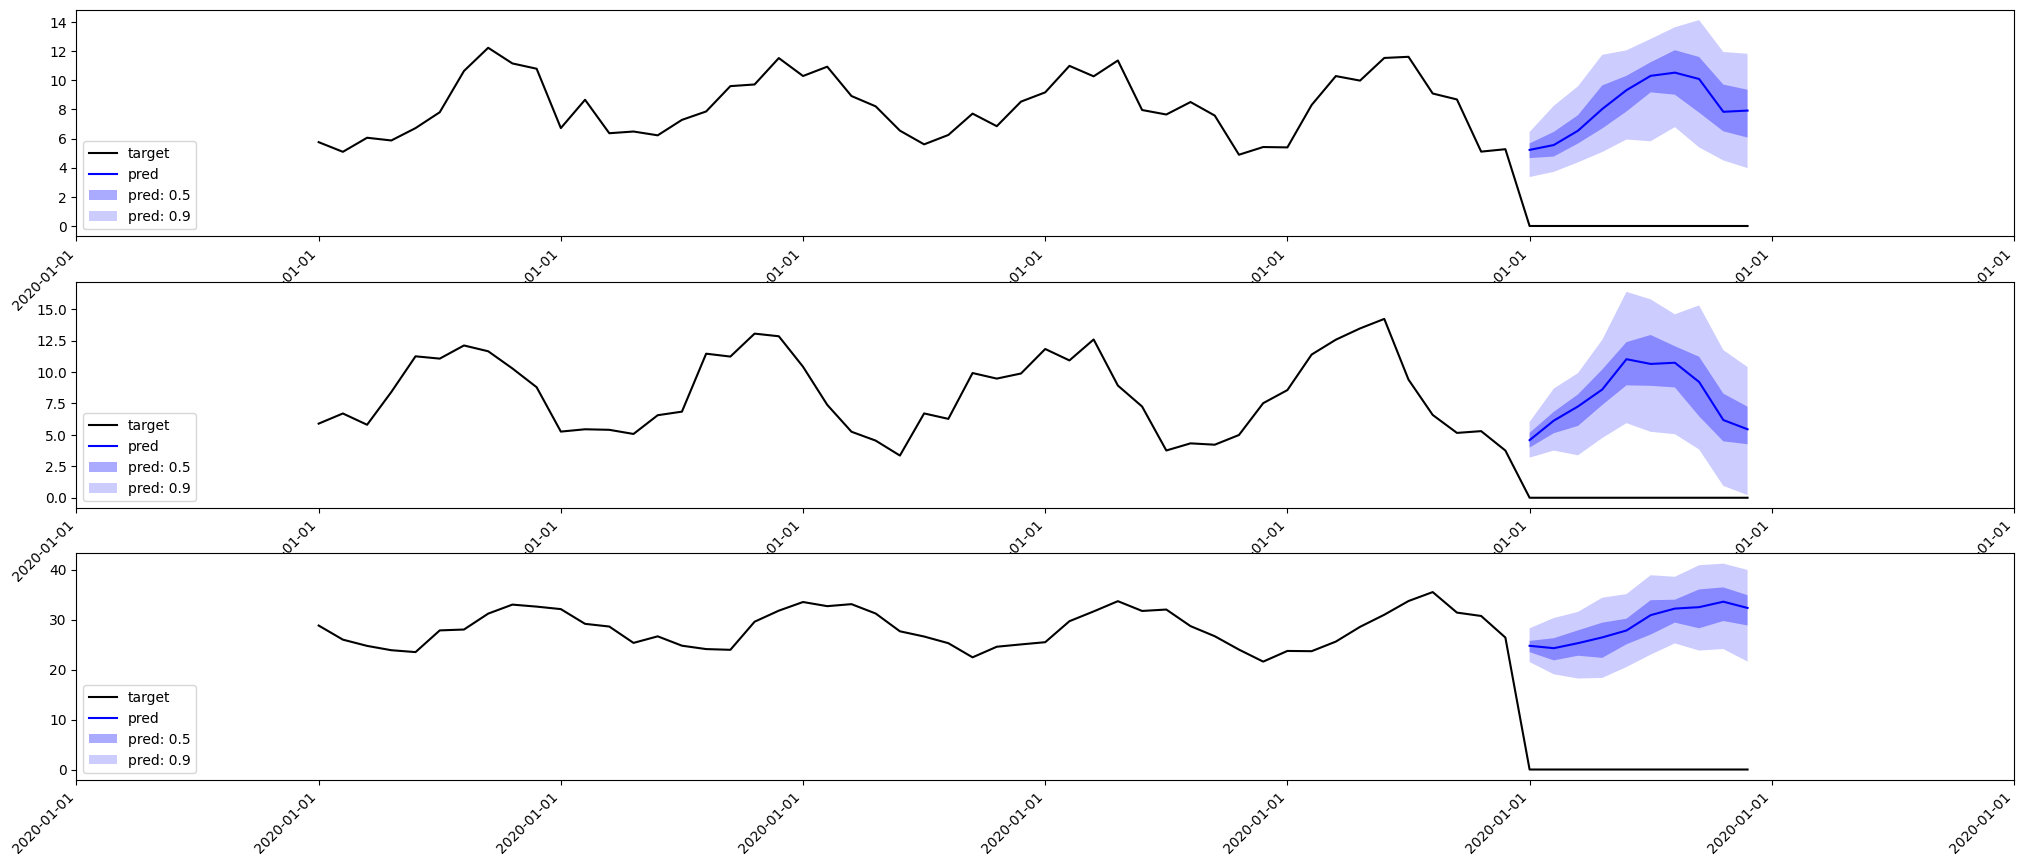

In [5]:

# Visualize different dimensions
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(25, 10))
for i, ax in enumerate(axes.flatten()):
    plot_single(
        inp,
        label,
        forecast,
        context_length=CTX,
        intervals=(0.5, 0.9),
        dim=i,
        ax=ax,
        name="pred",
        show_label=True,
    )

## Create Prediction Matrix

In [8]:

target = np.concatenate([inp["target"], label["target"]], axis=-1) 
start = inp["start"]

pred = forecast.quantile(0.5)

print("Initial shape:", pred.shape)
print("Train shape:", train_mat.shape)

# Perform pair_id specific operations
if pair_id in [2, 4]:
    # Reconstruction
    pred = np.vstack([train_mat, pred])
elif pair_id in [1, 3, 5, 6, 7]:
    # Forecast
    pass
elif pair_id in [8, 9]:
    # Burn-in
    pred = np.vstack([train_mat, pred])
else:
    raise ValueError(f"Pair id {pair_id} not supported") 

print("Final shape:", pred.shape)


Initial shape: (10, 3)
Train shape: (100, 3)
Final shape: (110, 3)
